In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfl = tf.keras.layers
tfpl = tfp.layers

In [2]:
# Loading the mnist dataset
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

# Change dtype to float
x_train = tf.cast(x_train, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0

# Info about shapes
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [3]:
# Some parameters used in the paper
latent_dims = 40
n_hidden_units = 300
n_epochs = 100
batch_size = 100
img_shape = x_train.shape[1:]
# input_shape = [img_shape[0], img_shape[1], 1]
input_shape = img_shape

In [4]:
# Define the prior
prior = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros(latent_dims),
        scale=1.0,
    ),
    reinterpreted_batch_ndims=1,
)

In [5]:
# Create the archicture
encoder = tfk.Sequential([
    tfl.InputLayer(input_shape=input_shape),
    tfl.Flatten(),
    tfl.Dense(n_hidden_units, activation="relu"),
    tfl.Dense(n_hidden_units, activation="relu"),
    tfl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dims)),
    tfpl.MultivariateNormalTriL(latent_dims, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [6]:
decoder = tfk.Sequential([
    tfl.InputLayer(input_shape=[latent_dims,]),
    tfl.Dense(n_hidden_units, activation="relu"),
    tfl.Dense(n_hidden_units, activation="relu"),
    tfl.Dense(tfpl.IndependentBernoulli.params_size(input_shape)),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [7]:
vae = tfk.Model(inputs=encoder.input, outputs=decoder(encoder.output))


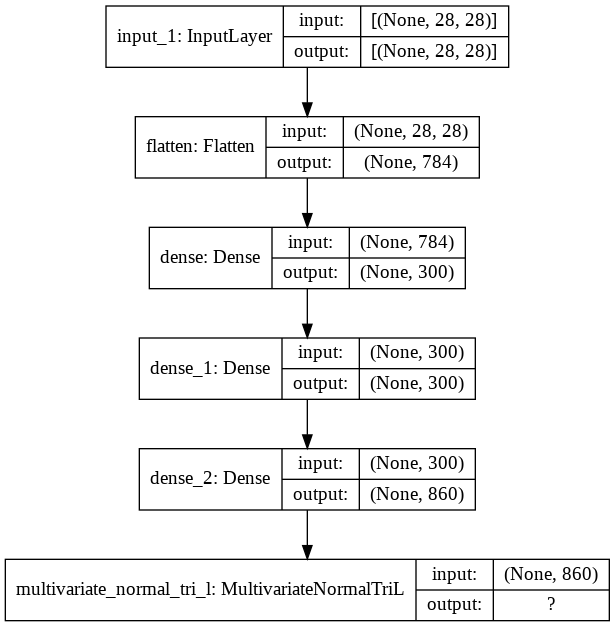

In [8]:
tfk.utils.plot_model(encoder, show_shapes=True)


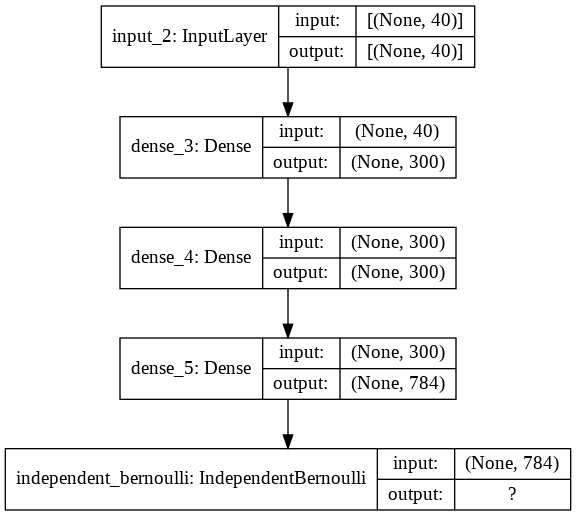

In [9]:
tfk.utils.plot_model(decoder, show_shapes=True)

In [10]:
neg_log_likelihood = lambda x, rv_x: - rv_x.log_prob(x)

vae.compile(optimizer=tfk.optimizers.Adam(learning_rate=1.0e-4), loss=neg_log_likelihood)

In [11]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [13]:
with tf.device("/device:GPU:0"):
  vae.fit(
      x=x_train,
      y=x_train,
      epochs=n_epochs,
      batch_size=batch_size,
  )

Epoch 1/100
600/600 [==============================] - 4s 3ms/step - loss: 199.4138
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 192.9086
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 190.7547
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 189.1682
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 182.7341
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 179.4263
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 176.5126
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: 172.3244
Epoch 9/100
600/600 [==============================] - 2s 3ms/step - loss: 168.0422
Epoch 10/100
600/600 [==============================] - 2s 3ms/step - loss: 165.6476
Epoch 11/100
600/600 [==============================] - 2s 3ms/step - loss: 163.1724
Epoch 12/100
600/600 [==============================] - 2s 3ms/step - loss

In [15]:
# TODO : Check KL divergence between the variational encoder and the prior
